In [1]:
# DATA_PATH = 'data/hdmb'
DATA_PATH = ['data/hdmb','data/from_felixchenfy','data/from_ChengeYang']
### csv must be  id|xxx|xxx|nose|LEye.......


alphaI2W = [ "nose","LEye","REye","LEar","REar","LShoulder","RShoulder", "LElbow","RElbow",\
"LWrist", "RWrist","LHip","RHip", "LKnee","Rknee", "LAnkle","RAnkle"]

# tagI2W = ["jump","run","sit","stand","walk"] # 5
tagI2W = ["jump","kick","punch","run","sit","squat","stand","walk","wave"] # 9
tagW2I = {w:i for i,w in enumerate(tagI2W)}

In [2]:
import os
import pandas as pd 
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

parpath = os.path.dirname(os.getcwd())
sys.path.append(parpath)

torch.manual_seed(42)

In [3]:
N_EPOCHS = 1000
BATCH_SIZE = 32
SHUFFLE = True
INPUT_DIM = 34
CLASS_NUM = len(tagI2W)
# device = 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from actRec.models import dnnSingle
model = dnnSingle(INPUT_DIM,CLASS_NUM,initrange=1.5).to(device)
criterion = nn.CrossEntropyLoss().to(device)
# model.double()
# model.cuda()
model

dnnSingle(
  (fc1): Linear(in_features=34, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=9, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [5]:
from dataset import SinglePoseDataset
from actRec.F import normalize_min_
class PoseActSingleDataFromCsvDir():
    def __init__(self, csvdirpaths,use_large=True):
        datas = []
        tags = []
        for csv_dir_path in csvdirpaths:
            csvlist = os.listdir(csv_dir_path)
            for fname in csvlist:
                if(os.path.isdir(fname)):continue
                if(os.path.splitext(fname)[1] != '.csv'):continue

                fnsp = fname.split('_')
                if(fnsp[0]=='large'):
                    if(not use_large): continue
                    tag = fnsp[1]
                else:
                    tag = fnsp[0] 
                if tag not in tagW2I:
                    continue

                tag = tagW2I[tag]
                csvf = os.path.join(csv_dir_path,fname)
                df = pd.read_csv(csvf)
                v = df.iloc[:,3:].values

                normalize_min_(v)

                for iv in v:
                    datas.append(iv)
                    tags.append(tag)

        self.X = np.array(datas)
        self.Y = np.array(tags)

    def __len__(self):
        return len(self.X)
    
    def split(self,test_size=0.1, random_state=42):
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=test_size, random_state=random_state)
        return SinglePoseDataset(X_train,Y_train),SinglePoseDataset(X_test,Y_test)

In [6]:
# from torch_inspect import summary
# summary(model,[(1,7,34),(1)])
PoseActSingleDataFromCsvDir(DATA_PATH).__len__()

18969

In [7]:
from sklearn.model_selection import train_test_split
train_data,test_data = PoseActSingleDataFromCsvDir(DATA_PATH).split()

In [8]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=SHUFFLE)

In [9]:
def model_eval(batch):
    label_ = torch.LongTensor(batch['tag']).to(device)
    input_= batch['data'].to(device)
    
    out = model(input_) # data,datalen
    loss = criterion(out, label_)
    
    batch_acc = (out.argmax(1) == label_).sum().item()
    return loss,batch_acc

In [10]:
# optimizer = optim.SGD(model.parameters(), lr=0.05)
optimizer = optim.Adadelta(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.4)

In [11]:
import procession as pc
import time
_epoch = -1

t = time.localtime(time.time())
timestr = '%d-%d-%d_%d-%d'%(t[0],t[1],t[2],t[3],t[4])
savepath = 'model/act_dnnSingle%d_'%len(tagI2W)
savepath +=timestr

os.chdir(parpath)
if not os.path.exists(savepath):
    os.makedirs(savepath)

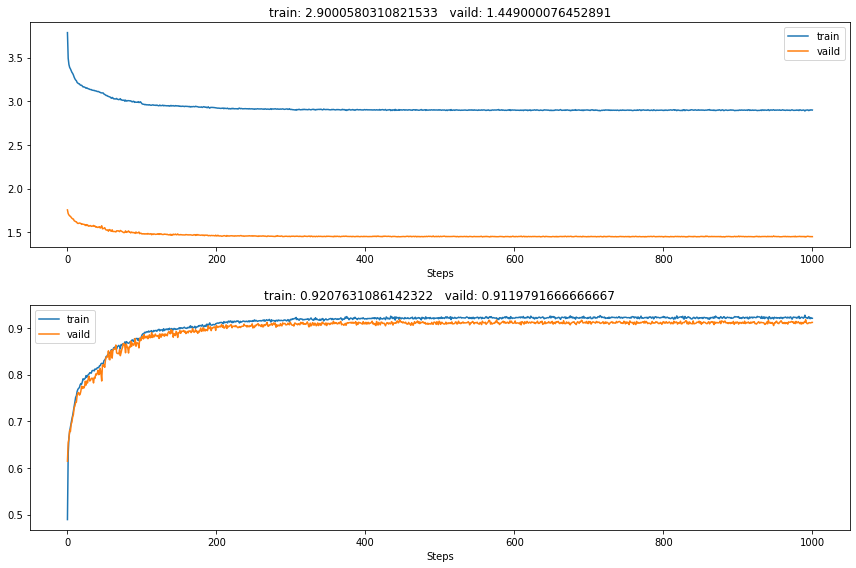


 Tue May 19 18:55:17 2020
Epoch: 1000  | time in 0 minutes, 2 seconds
	Loss: 2.9001(train)	|	Acc: 92.1%(train)
	Loss: 1.4490(valid)	|	Acc: 91.2%(valid)
SAVING EPOCH 1000


In [12]:
import hiddenlayer as hl
train_his = hl.History()
vaild_his = hl.History()
canvas1 = hl.Canvas()
for epoch in range(_epoch+1,N_EPOCHS+1):
    start_time = time.time()
    train_loss, train_acc = pc.train_epoch(model,train_loader,model_eval,optimizer,scheduler,BATCH_SIZE)
    valid_loss, valid_acc = pc.evaluate(model,test_loader,model_eval,BATCH_SIZE)
    train_his.log(epoch, loss=train_loss, accuracy=train_acc)
    vaild_his.log(epoch, loss=valid_loss, accuracy=valid_acc)
    with canvas1:
        canvas1.draw_plot([train_his["loss"], vaild_his["loss"]],labels=["train", "vaild"])
        canvas1.draw_plot([train_his["accuracy"], vaild_his["accuracy"]],labels=["train", "vaild"])
    pc.print_train_info(start_time,epoch,train_loss,train_acc,valid_loss,valid_acc)
    _epoch=epoch
    info =  {'train_loss':train_loss,'train_acc':train_acc,'valid_loss':valid_loss,'valid_acc':valid_acc}
    if epoch % 500 ==0 and epoch != 0: 
        pc.save_model_with_info(model,optimizer,tagI2W,info,epoch,savepath)